## Setup

In [1]:
# scikeras library requires tensorflow >= 2.7.0
!pip install -U tensorflow==2.7.0
!pip install -U scikeras

     |████████████████████████████████| 489.6 MB 20 kB/s               
     |████████████████████████████████| 1.3 MB 35.0 MB/s            
     |████████████████████████████████| 2.1 MB 35.0 MB/s            
     |████████████████████████████████| 463 kB 57.2 MB/s            
     |████████████████████████████████| 14.5 MB 62.7 MB/s            
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.6.0
    Uninstalling tensorflow-estimator-2.6.0:
      Successfully uninstalled tensorflow-estimator-2.6.0
  Attempting uninstall: keras
    Found existing installation: keras 2.6.0
    Uninstalling keras-2.6.0:
      Successfully uninstalled keras-2.6.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.6.2
    Uninstalling tensorflow-2.6.2:
      Successfully uninstalled tensorflow-2.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is th

In [2]:
# load packages
import re
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd
pd.set_option('mode.chained_assignment',  None)

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve
from tensorflow import keras
from scikeras.wrappers import KerasClassifier

import eli5
from eli5.sklearn import PermutationImportance

2022-02-04 17:30:14.889432: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2022-02-04 17:30:14.889484: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
file_path = "../input/credit-risk-dataset/loan/loan.csv"
df = pd.read_csv(file_path, index_col=[0])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (19,55) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Data Cleaning and Formatting

There are 74 features in this dataset, and many of them show minor usability (mostly filled with NaNs, no variance, or duplicated to another). So I manually filtered the features that I found the most useful.

In [4]:
df.keys()

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term',
       'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose',
       'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt',
       'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'application_type',
       'annual_inc_joint', 'dti_joint', 'verification_status_joint',
       'ac

### Initial feature filtering

In [5]:
attribs_to_use = [
    'funded_amnt',          # actual amount funded to loans
    'term',                 # number of payments (month)
    'int_rate',             # interest rate
    'installment',          # monthly payment 
    'sub_grade',            # credit rating
    'emp_length',           # number of years of employment
    'home_ownership',       # home ownership status of each borrower
    'issue_d',              # the month which the loan was funded
    'loan_status',          # current status of the loan (=target variable)
    'purpose',              # purpose of the loan
    'dti',                  # debt to monthly income ratio
    'delinq_2yrs',          # number of 30+ days past-due incidences for last two years
    'earliest_cr_line',     # date each borrower's earliest reported credit line was opened
    'inq_last_6mths',       # number of inquiries in past 6 months
    'total_acc',            # total number of credit lines 
    'pub_rec',              # number of derogatory public records
    'revol_bal',            # total credit revolving balance
    'revol_util',           # total revolving utilization rate 
    'total_rec_late_fee',   # late fees received to date 
    'recoveries',           # post charge off gross recovery
    'last_pymnt_d',         # last month payment was received
    'last_pymnt_amnt',      # last month payment amount
    'last_credit_pull_d',   # the most recent month LC pulled credit for this loan
    'acc_now_delinq',       # number of delinquent accounts
    'total_pymnt',          # total payments received to date
    'annual_inc'
]

df_filter = df[attribs_to_use]

In [6]:
df_filter.shape

(887379, 26)

### Format dates

In [7]:
# select date columns
date_columns = [
    'issue_d', 
    'earliest_cr_line', 
    'last_pymnt_d', 
    'last_credit_pull_d'
]

# drop rows whose date is NaN
df_filter = df_filter.dropna(subset=date_columns)
df_filter = df_filter.reset_index(drop=True)

# format dates
for col in date_columns:
    df_filter.loc[:, col] = pd.to_datetime(df_filter[col])

df_filter[date_columns].head()

,issue_d,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,2011-12-01,1985-01-01,2015-01-01,2016-01-01
1,2011-12-01,1999-04-01,2013-04-01,2013-09-01
2,2011-12-01,2001-11-01,2014-06-01,2016-01-01
3,2011-12-01,1996-02-01,2015-01-01,2015-01-01
4,2011-12-01,1996-01-01,2016-01-01,2016-01-01


### Format target variable

The `loan_status` is the target variable here containing ten different classes with an imbalanced number of observations. Since this project aims to build a classifier to find defaultable accounts in advance, I prefered to divide them into two groups.

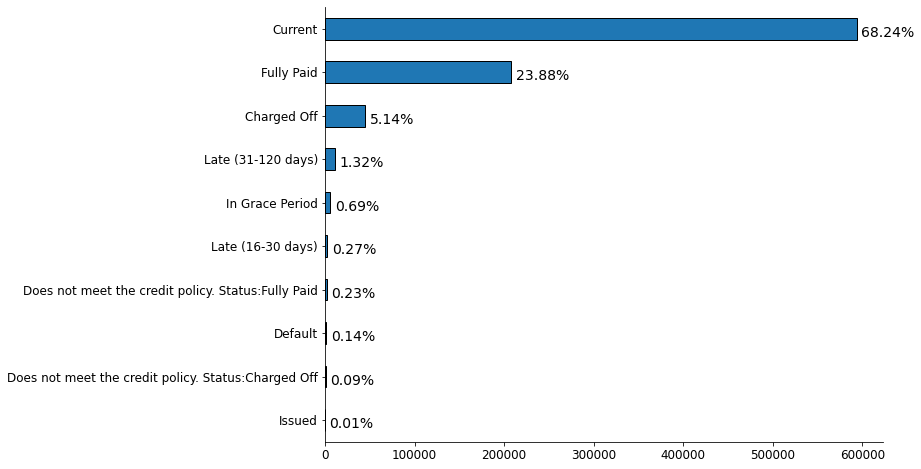

In [8]:
plt.figure(figsize=(10,8))

ax = df_filter['loan_status'].value_counts().sort_values().plot.barh(edgecolor='black', grid=False, fontsize=12)

for p in ax.patches:
    width = p.get_width()
    ax.text(width+5000, p.get_y(), '{:.2%}'.format(width/len(df_filter)), ha='left', va='bottom', fontsize=14)

sns.despine()    

In [9]:
# removed the 'Issued' class since these loans just got approved and have not begun any repayment processes yet
issue = df_filter['loan_status'] == 'Issued'
df_filter_issue = df_filter[~issue]

# binary classification
label_categories = [
    (0, ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid', 'Current']),
    (1, ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period', 
         'Charged Off', 'Default', 'Does not meet the credit policy. Status:Charged Off'])
]

# function to apply the transformation
def classify_label(text):
    for category, matches in label_categories:
        if any(match in text for match in matches):
            return category
    return None

df_filter_issue.loc[:, 'label'] = df_filter_issue['loan_status'].apply(classify_label)
df_filter_issue = df_filter_issue.drop('loan_status', axis=1)

# check label classes imbalance
neg, pos = np.bincount(df_filter_issue['label'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 869592
    Positive: 66498 (7.65% of total)



### Customized formatting for other columns

> 1.4.1 `home_ownership`

Some of categories in this data only have a few observations (`OTHER`, `NONE`, `ANY`). Simply combine them into one.

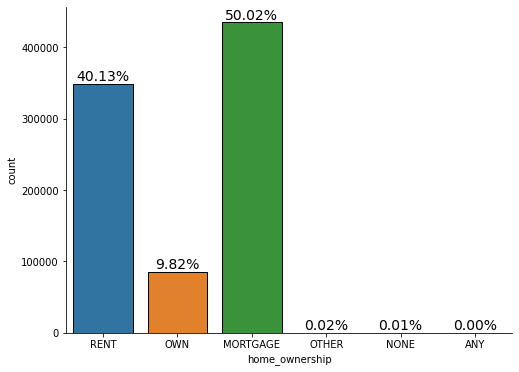

In [10]:
plt.figure(figsize=(8,6))

ax = sns.countplot(x='home_ownership', data=df_filter_issue, edgecolor='black')

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+.4, height, '{:.2%}'.format(height/len(df_filter)), ha='center', va='bottom', fontsize=14)

sns.despine()

In [11]:
df_filter_issue['home_ownership'] = df_filter_issue['home_ownership'].replace(['NONE', 'ANY'], 'OTHER')

> 1.4.2 `emp_length`

Convert it to a numeric form while keeping nan values.

In [12]:
df_filter_issue['emp_length'].unique()

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [13]:
# copy the feature
emp_length = df_filter_issue['emp_length'].copy()

# select not null values
emp_length_nonull = emp_length.dropna()

# manually replace '< 1 year' to '0'
emp_length_nonull = emp_length_nonull.replace('< 1 year', '0')

# format the rest by removing all strings except for numbers
emp_length_encode = [re.sub('[<years+ ]', '', txt) for txt in emp_length_nonull]

# squeeze back to the original dataset
emp_length[emp_length.notnull()] = np.squeeze(emp_length_encode)
df_filter_issue.loc[:, 'emp_length'] = emp_length

df_filter_issue['emp_length']

0         10
1          0
2         10
3         10
4          1
          ..
869635     8
869636    10
869637     5
869638     1
869639    10
Name: emp_length, Length: 869592, dtype: object